In [1]:
%matplotlib inline

In [2]:

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal, ndimage, misc

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Dropout, GaussianNoise
from keras.layers import Convolution2D, Deconvolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Convolution3D, UpSampling3D, MaxPooling3D
from keras.models import Model
from keras import regularizers
from keras import backend as K_backend
from keras import objectives
from keras.datasets import mnist


Using TensorFlow backend.


In [3]:
from matplotlib.pyplot import imshow
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [4]:
def nimshow(img):
    plt.imshow(img, interpolation='none')
    
def conv(img, kern, renorm=False):
    ift = signal.fftconvolve(img, kern, 'same')
    if renorm:
        ift /= np.amax(ift)
    return ift

def ricker2d(x, y, f=np.pi, n=0.5):
    r = (x**2 + y**2)**n
    return (1.0 - 2.0*(np.pi**2)*(f**2)*(r**2)) * np.exp(-(np.pi**2)*(f**2)*(r**2))

def gauss2d(x, y, f=1, sig=1, n=0.5):
    r = (x**2 + y**2)**n
    return np.exp(-((f*r)**2)/(.25*sig**2))

In [5]:
def plot_3d(image, threshold=-300, azim=45, elev=45):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
#     p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.azim = azim
    ax.elev = elev

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
def splay(volume, rows=5, cols=5):
    fig = plt.figure(figsize=(10, 10))
    n = rows*cols
    for i in range(rows):
        for j in range(cols):
            fig.add_subplot(rows, cols, cols*i+j+1)
            plt.imshow(volume[cols*i+j])

    
    
class Crossfire(object):
    """
    Covolutional VAE with a "crossfire" component - a classifier is bolted onto the end of the encoder and loss function
    can be parameterized to function from classifier loss instead of autoencoder loss. Ideally, the model starts in
    pure autoencoder mode to learn features, then as loss flattens out the network starts weighing classifier loss
    more heavily.
    Note to self: things to try:
    * Add burst /batch / epoch noise to input
    * Modularize out the activation from dropout ordering"""

    def __init__(self, input_shape=(28, 28, 1), latent_dim=2, intermediate_dim=256, batch_size=100, epsilon_std=1.0,
                 dropout_p=0.1, n_stax=0, n_classes=10):
        # input image dimensions
        self.input_shape = input_shape
        if len(input_shape) == 3:
            self.img_rows, self.img_cols, self.img_chns = input_shape
        elif len(input_shape) == 2:
            self.img_rows, self.img_cols = input_shape
            self.img_chns = 1
        else:
            raise IndexError("Invalid shape: {}".format(input_shape))
        self.batch_size = batch_size
        self.original_dim = np.prod(input_shape)
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.epsilon_std = epsilon_std
        self.epsilon_ce = 1.0e-9

        # number of convolutional filters to use
        nb_filters = 64
        # convolution kernel size
        nb_conv = 3

        if K_backend.image_dim_ordering() == 'th':
            self.original_img_size = (self.img_chns, self.img_rows, self.img_cols)
        else:
            self.original_img_size = (self.img_rows, self.img_cols, self.img_chns)

        x = Input(batch_shape=(batch_size,) + self.original_img_size, name='main_input')
        conv_1 = Convolution2D(self.img_chns, 2, 2, border_mode='same', activation='relu')(x)
        conv_2 = Convolution2D(nb_filters, 2, 2,
                               border_mode='same', activation='relu', subsample=(2, 2))(conv_1)
        conv_3 = Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='same', activation='relu', subsample=(1, 1))(
            conv_2)
        for i in range(n_stax):
            conv_3 = BatchNormalization()(conv_3)
            conv_3 = Dropout(dropout_p)(conv_3)
            conv_3 = Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='same', activation='relu',
                                   subsample=(1, 1))(conv_3)

        conv_3 = BatchNormalization()(conv_3)
        conv_4 = Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='same', activation='relu', subsample=(1, 1))(
            conv_3)
        flat = Flatten()(conv_4)
        hidden = Dense(intermediate_dim, activation='relu', name='intermed')(flat)

        self.z_mean = Dense(latent_dim, name='z_mean')(hidden)
        self.z_log_var = Dense(latent_dim, name='z_log_var')(hidden)

        # note that "output_shape" isn't necessary with the TensorFlow backend
        # so you could write `Lambda(sampling)([z_mean, z_log_var])`
        z = Lambda(self.sampling, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])

        ## ==== End of encoding portion ======

        ## ==== Crossfire classifier =========
        #         c = Lambda(self.crosser, output_shape=(latent_dim,))(self.z_mean, self.z_log_var)
        classer = Dense(n_classes, init='normal', activation='softmax', name='classer')(self.z_mean)

        # Slicer example
        # y = Lambda(lambda x: x[:,0,:,:], output_shape=(1,) + input_shape[2:])(x)




        # we instantiate these layers separately so as to reuse them later
        decoder_hid = Dense(intermediate_dim, activation='relu')
        decoder_upsample = Dense(nb_filters * 14 * 14, activation='relu')

        if K_backend.image_dim_ordering() == 'th':
            output_shape = (batch_size, nb_filters, 14, 14)
        else:
            output_shape = (batch_size, 14, 14, nb_filters)

        decoder_reshape = Reshape(output_shape[1:])
        decoder_deconv_1 = Deconvolution2D(nb_filters, nb_conv, nb_conv, output_shape, border_mode='same',
                                           subsample=(1, 1), activation='relu')
        decoder_deconv_2 = Deconvolution2D(nb_filters, nb_conv, nb_conv, output_shape, border_mode='same',
                                           subsample=(1, 1), activation='relu')
        if K_backend.image_dim_ordering() == 'th':
            output_shape = (batch_size, nb_filters, 29, 29)
        else:
            output_shape = (batch_size, 29, 29, nb_filters)
        decoder_deconv_3_upsamp = Deconvolution2D(nb_filters, 2, 2, output_shape,
                                                  border_mode='valid', subsample=(2, 2), activation='relu')
        decoder_mean_squash = Convolution2D(self.img_chns, 2, 2, border_mode='valid',
                                            activation='sigmoid', name='main_output')

        hid_decoded = decoder_hid(z)
        up_decoded = decoder_upsample(hid_decoded)
        reshape_decoded = decoder_reshape(up_decoded)
        deconv_1_decoded = decoder_deconv_1(reshape_decoded)
        deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
        x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
        x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

        # build a digit generator that can sample from the learned distribution
        # todo: (un)roll this
        decoder_input = Input(shape=(latent_dim,))
        _hid_decoded = decoder_hid(decoder_input)
        _up_decoded = decoder_upsample(_hid_decoded)
        _reshape_decoded = decoder_reshape(_up_decoded)
        _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
        _deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
        _x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
        _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)

        # Generate models
        # Primary model - VAE
        self.model = Model(x, x_decoded_mean_squash)
        # Crossfilre network
        self.classifier = Model(x, classer)
        # Ok, now comes the tricky part. See these references:
        # https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
        self.crossmodel = Model(input=x, output=[x_decoded_mean_squash, classer])
        self.crossmodel.compile(optimizer='rmsprop',
                                loss={'main_output': self.vae_loss,
                                      'classer': 'categorical_crossentropy'},
                                loss_weights={'main_output': 1.0,
                                              'classer': 5.0})

        # build a model to project inputs on the latent space
        self.encoder = Model(x, self.z_mean)
        # reconstruct digits from latent space
        self.generator = Model(decoder_input, _x_decoded_mean_squash)
        self.model.compile(optimizer='rmsprop', loss=self.vae_loss)
        self.classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #         self.classifier.compile(loss=self.custom_crossent, optimizer='adam', metrics=['accuracy'])


    def fit_crossmodel(self, x_dict, y_dict, batch_size=None, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.,
                       validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        callbacks_history = self.crossmodel.fit(x_dict, y_dict, batch_size, nb_epoch, verbose, callbacks,
                                                validation_split,
                                                validation_data, shuffle, class_weight, sample_weight)
        return callbacks_history

    def sampling(self, args):
        z_mean, z_log_var = args
        epsilon = K_backend.random_normal(shape=(self.batch_size, self.latent_dim),
                                          mean=0., std=self.epsilon_std)
        return z_mean + K_backend.exp(z_log_var) * epsilon

    def crosser(self, args):
        z_mean, z_log_var = args
        return z_mean

    def vae_loss(self, x, x_decoded_mean):
        # NOTE: binary_crossentropy expects a batch_size by dim
        # for x and x_decoded_mean, so we MUST flatten these!
        x = K_backend.flatten(x)
        x_decoded_mean = K_backend.flatten(x_decoded_mean)
        xent_loss = self.img_rows * self.img_cols * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K_backend.mean(
            1 + self.z_log_var - K_backend.square(self.z_mean) - K_backend.exp(self.z_log_var), axis=-1)
        return xent_loss + kl_loss

    def custom_crossent(self, y_true, y_pred):
        '''Just another crossentropy'''

        #         y_pred = K_backend.clip(y_pred, self.epsilon_ce, 1.0 - self.epsilon_ce)
        #         y_pred /= K_backend.sum(y_pred, axis=-1, keepdims=True)
        cce = K_backend.categorical_crossentropy(y_pred, y_true)
        return cce

    def fit(self, x, y, batch_size=None, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.,
            validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        callbacks_history = self.model.fit(x, y, batch_size, nb_epoch, verbose, callbacks, validation_split,
                                           validation_data, shuffle, class_weight, sample_weight)
        return callbacks_history

    def fit_ae(self, x, batch_size=None, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.,
               validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        callbacks_history = self.model.fit(x, x, batch_size, nb_epoch, verbose, callbacks, validation_split,
                                           validation_data, shuffle, class_weight, sample_weight)
        return callbacks_history

    def crossfit(self, x, y, batch_size=None, nb_epoch_ae=5, nb_epoch_cf=10, verbose=1, callbacks=[],
                 validation_split=0.,
                 validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        valid_ae, valid_cf = validation_data
        for i in range(nb_epoch_ae):
            callbacks_history = self.model.fit(x, x, batch_size, 1, verbose, callbacks, validation_split,
                                               valid_ae, shuffle, class_weight, sample_weight)
        for i in range(nb_epoch_cf):
            callbacks_history = self.classifier.fit(x, y, batch_size, 1, verbose, callbacks, validation_split,
                                                    valid_cf, shuffle, class_weight, sample_weight)
        return callbacks_history

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
# x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
std_x_mean = np.mean(x_train, axis=0)

In [9]:
std_x_train = np.std(x_train, axis=0)

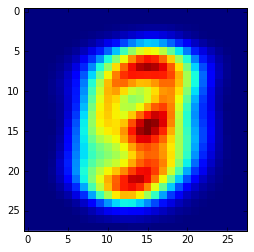

In [10]:
nimshow(std_x_mean)

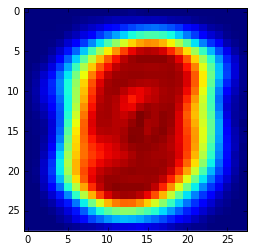

In [11]:
nimshow(std_x_train)

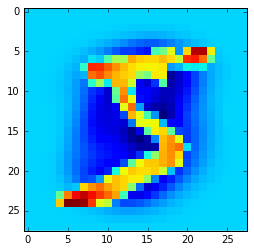

In [13]:
nimshow((x_train[0] - std_x_mean))

/home/mike/ve/ml/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


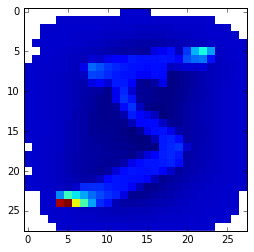

In [14]:
nimshow((x_train[0] - std_x_mean) / std_x_train)

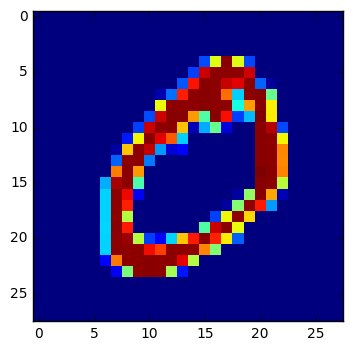

In [8]:
ns = 1
nimshow(x_train[ns])

In [9]:
valmax = 1
px = x_train.shape[1]
ax = np.linspace(-valmax, valmax, px, endpoint=False)
ay = np.linspace(-valmax, valmax, px, endpoint=False)
az = np.linspace(-px//2, px//2, px, endpoint=False)
xv, yv = np.meshgrid(ax, ay, sparse=False)
rad2 = xv**2 + yv**2
rad = rad2**2
az = np.roll(az, px//2)
az = np.abs(az)
az += 1
# az[az < 1] = 1
az

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,
         7.,   6.,   5.,   4.,   3.,   2.])

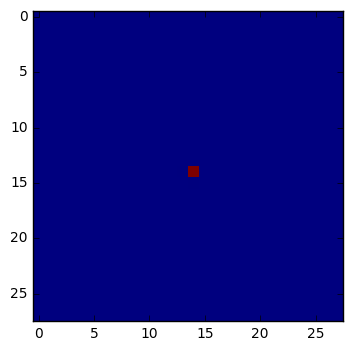

In [10]:
k_rick = ricker2d(xv, yv, 14)
nimshow(k_rick)

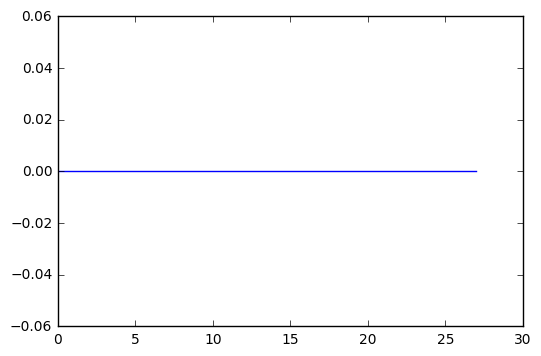

In [11]:
plt.plot(k_rick[4])

In [12]:
k3_rick = np.array([ricker2d(xv, yv, zv) for zv in az])
k3_gaus = np.array([gauss2d(xv, yv, np.abs(zv)) for zv in az])
k3_rick.shape

(28, 28, 28)

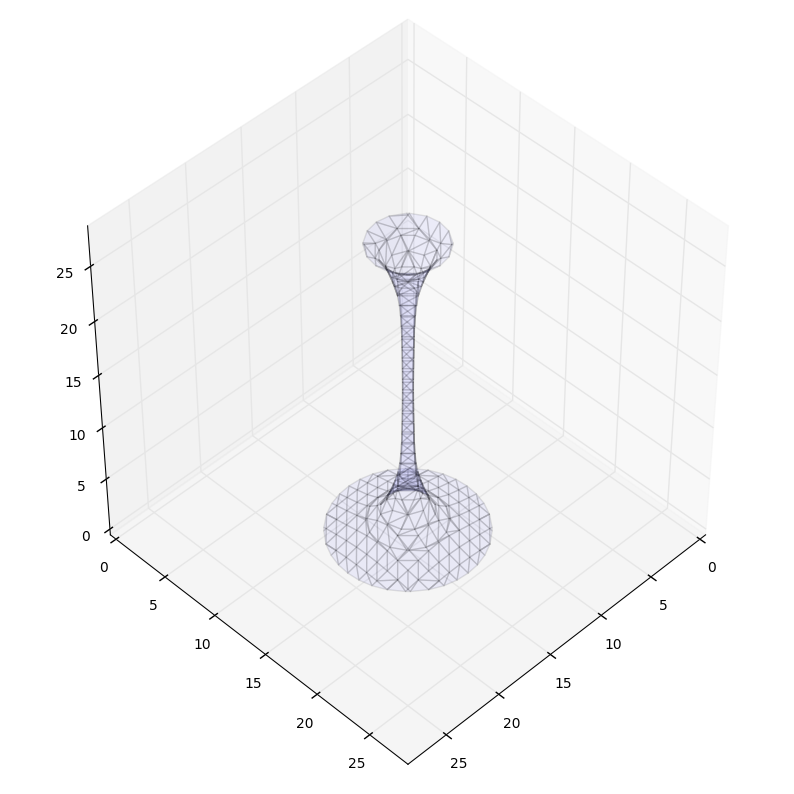

In [13]:
plot_3d(1-k3_gaus, .5)

In [14]:
samp = np.array([conv(x_train[ns], kern, renorm=True)> .90 for kern in k3_gaus])


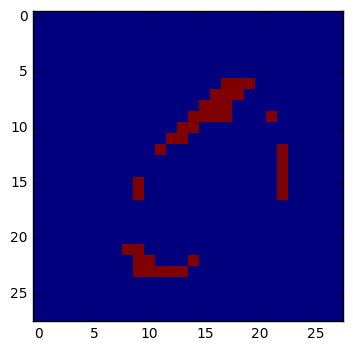

In [15]:
nimshow(samp[20])

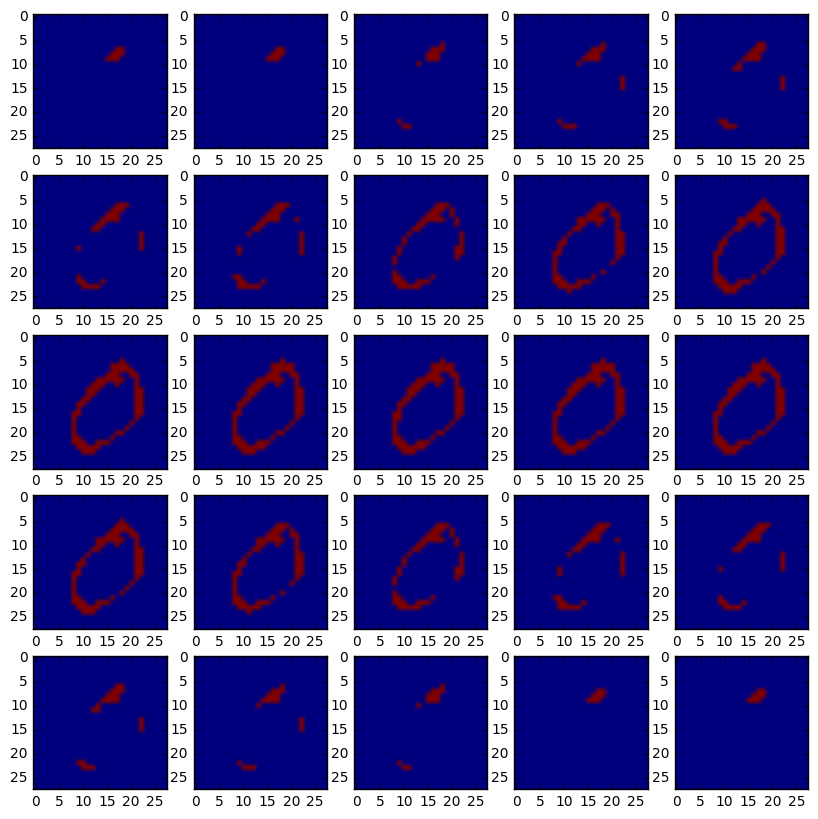

In [16]:
splay(samp[2:-1])

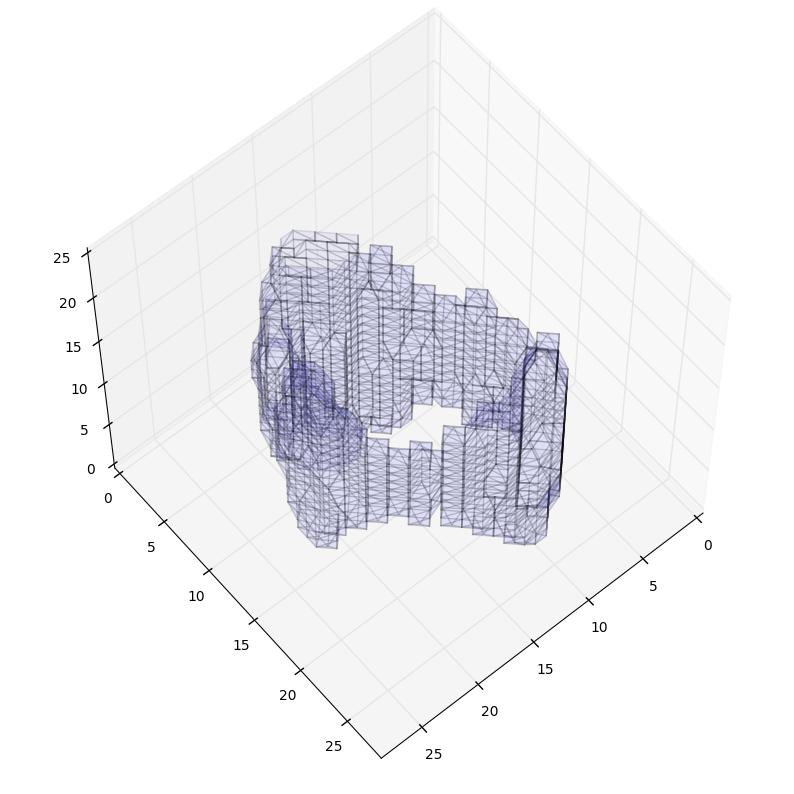

In [17]:
# %pylab qt
plot_3d(1-samp[2:-1], threshold=.999, azim=50, elev=60)

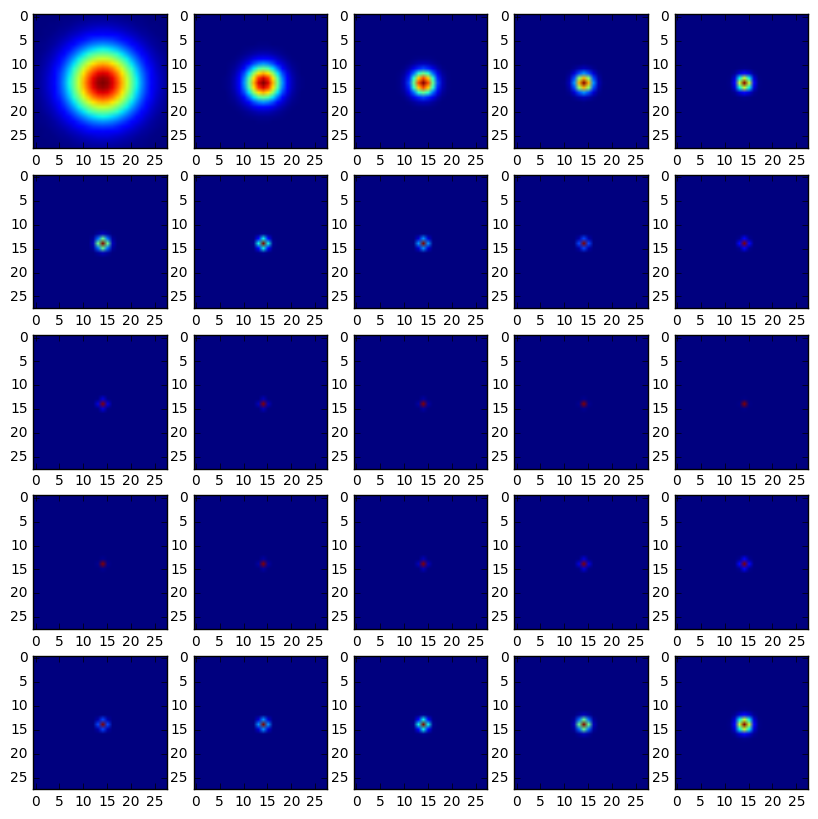

In [18]:
splay(k3_gaus)

In [19]:
def inflate_mnist(img, thresh=0.8, px=28, valmax=1, renorm=True):
    def gauss2d(x, y, f=1, sig=1, n=0.5):
        r = (x**2 + y**2)**n
        return np.exp(-((f*r)**2)/(.25*sig**2))
    ax = np.linspace(-valmax, valmax, px, endpoint=False)
    ay = np.linspace(-valmax, valmax, px, endpoint=False)
    az = np.linspace(-px//2, px//2, px, endpoint=False)
    xv, yv = np.meshgrid(ax, ay, sparse=False)
    rad2 = xv**2 + yv**2
    rad = rad2**2
    az = np.roll(az, px//2)
    az = np.abs(az)
    az += 1
    k3_gaus = np.array([gauss2d(xv, yv, np.abs(zv)) for zv in az]) # create "3D" kernel (really, slices of 2D)
    # create volume by blurring and thresholding (simulated erosion)
    vol = [conv(img, kern, renorm=renorm) for kern in k3_gaus]
    vol *= np.greater(vol,thresh)
    return np.array(vol)



In [20]:
vol = inflate_mnist(x_train[2], renorm=True)
vol.shape

(28, 28, 28)

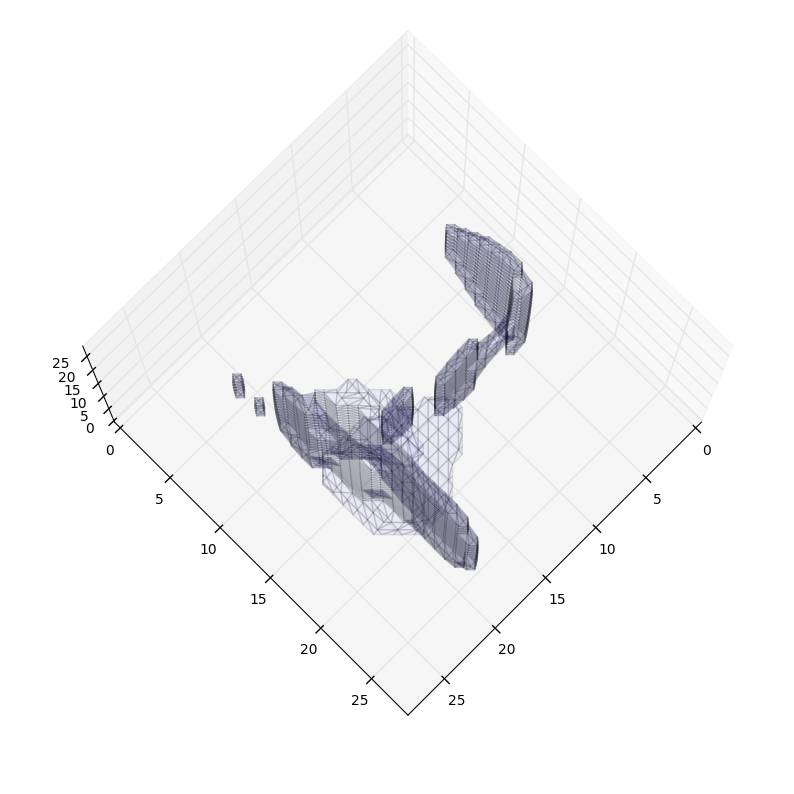

In [21]:
plot_3d(vol, threshold=.5, elev=80)

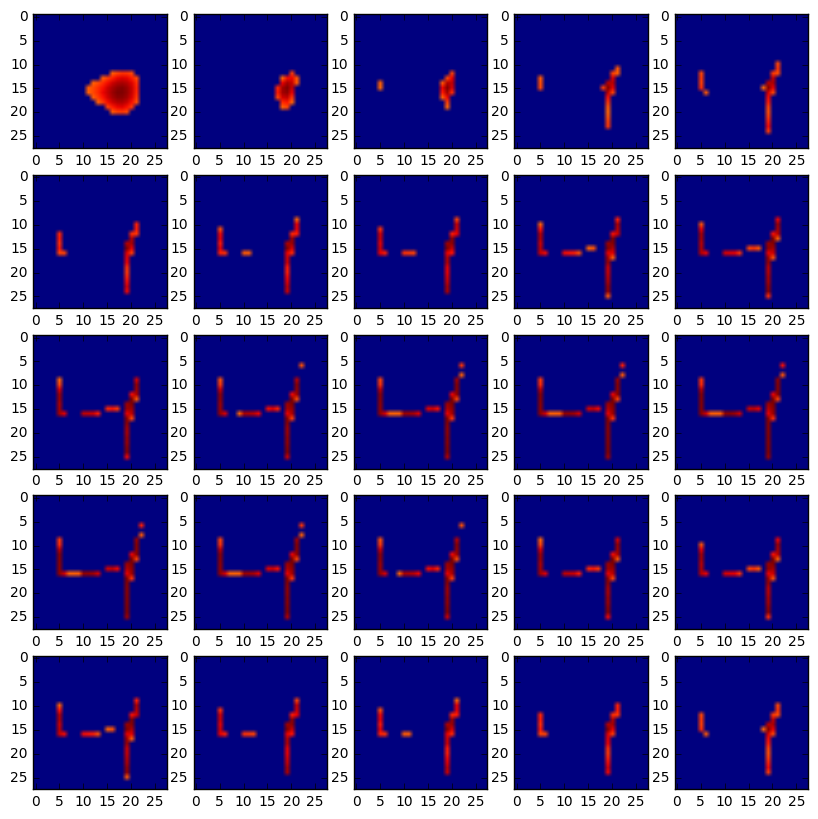

In [22]:
splay(vol)

In [ ]:
assert 0, 'halt'

In [25]:
%%timeit
vols = [inflate_mnist(img) for img in x_train[:100]]

1 loop, best of 3: 687 ms per loop


In [26]:
vols = [inflate_mnist(img) for img in x_train[:1000]]

3


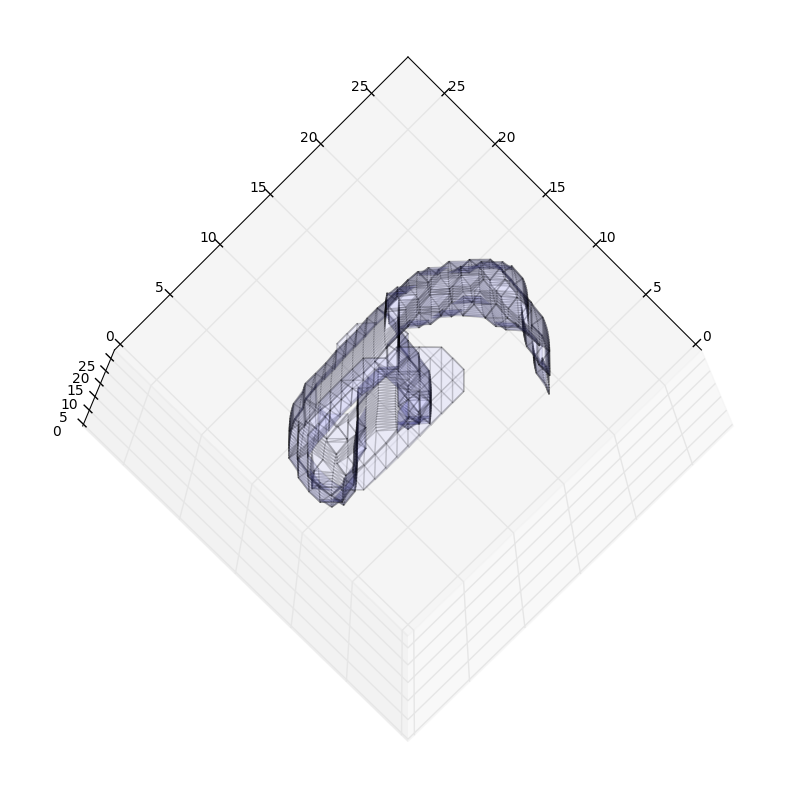

In [27]:
idx = 10
print(y_train[idx])
plot_3d(vols[idx], threshold=.8, elev=-80)

In [31]:
np.save('x_train_mnist3d_1k', vols)
# 168M for the first 1000 volumes. Total mnist 3d set equals...
168*60

10080

In [29]:
ll -lah

total 169M
drwxrwxr-x 3 mike 4.0K Jan 26 16:17 ./
drwxrwxr-x 6 mike 4.0K Jan 25 15:53 ../
-rw-rw-r-- 1 mike 1.1M Jan 26 16:16 autoencoder3d_01.ipynb
drwxr-xr-x 2 mike 4.0K Jan 25 15:53 .ipynb_checkpoints/
-rw-rw-r-- 1 mike 168M Jan 26 16:17 x_train_mnist3d_1k.npy


In [32]:
assert 0, 'This will use nearly 14 GB memory!!!!'
vols_xtrain = [inflate_mnist(img) for img in x_train[:10000]]

AssertionError: This will use nearly 14 GB memory!!!!

In [ ]:
# np.save('x_train_mnist3d', vols_xtrain)

In [ ]:
class Convo3d(object):
    def __init__(self):
        input_img = Input(shape=(1, 28, 28))

        x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
        x = MaxPooling2D((2, 2), border_mode='same')(x)
        x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
        x = MaxPooling2D((2, 2), border_mode='same')(x)
        x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
        encoded = MaxPooling2D((2, 2), border_mode='same')(x)

        # at this point the representation is (8, 4, 4) i.e. 128-dimensional

        x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Convolution2D(16, 3, 3, activation='relu')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)